### Install dependencies

In [1]:
!pip install boto3 sagemaker

Defaulting to user installation because normal site-packages is not writeable


### Setup

1. Create a new endpoint at https://us-east-2.console.aws.amazon.com/sagemaker/home?region=us-east-2#/endpoints then set `ENDPOINT` to it's name.
2. You can do inference in a single file or in a entire folder, set the path to it using `INPUT_PATH`

In [2]:
ENDPOINT = "your_endpoint_name"

# local file or folder
INPUT_PATH = "./input/forklift/"
# INPUT_PATH = "./drones.jpg"

### Run inference

Now that we have set the paths, we will run the images thuru amazon sagemaker's endpoint.

Note: This assumes you have created the endpoint and a IAM access been configured.

In [3]:
import os
import glob
import json
import boto3
import sagemaker

ALLOWED_EXTENSIONS = set(['png', 'jpg', 'jpeg', 'gif', 'webp', 'bmp'])

def getFiles(base):
    if os.path.isfile(base):
        return [base]
    else:
        return glob.glob(os.path.join(base, '**'), recursive=True)
    
# initalize client
sagemaker = boto3.client(
    'runtime.sagemaker',
    region_name='us-east-2'
)

flist = getFiles(INPUT_PATH)
print("Processing: {} files...".format(len(flist)))

for fpath in flist:
    ext = fpath.split('.')[-1].lower() if '.' in fpath else None
    
    # skip unsupported / invalid file extensions
    if ext is None or ext not in ALLOWED_EXTENSIONS:
        continue
    
    # load input
    with open(fpath, 'rb') as fh:
        payload = fh.read()

    # invoke inference
    result = sagemaker.invoke_endpoint(
            EndpointName=ENDPOINT,
            ContentType='image/{}'.format(ext),
            Body=bytearray(payload))

    # sagemaker request raw response
    # print('sagemaker response:\n\n', result, '\n')

    # inference response
    print('file: {} inference response:\n{}\n'.format(
        fpath,
        json.dumps(json.loads(result['Body'].read().decode()), sort_keys=True, indent=4))
    )

Processing: 11 files...
file: ./input/forklift/video_4.mkv_020.jpg inference response:
{
    "input.jpg": {
        "detections": [
            {
                "classid": 16,
                "confidence": 0.9999134540557861,
                "det_bbox": [
                    0.5605989694595337,
                    0.2426413595676422,
                    0.8468234539031982,
                    0.7448790073394775
                ],
                "label": "forklift",
                "scan": "global"
            }
        ]
    }
}

file: ./input/forklift/video_4.mkv_017.jpg inference response:
{
    "input.jpg": {
        "detections": [
            {
                "classid": 16,
                "confidence": 0.6614300012588501,
                "det_bbox": [
                    0.17102140188217163,
                    0.08342009782791138,
                    0.7744635343551636,
                    0.8797507286071777
                ],
                "label": "forklift",
            

## Run inference and draw

In this example we will draw the bounding boxes into the images

This requires OpenCV2 and matplotlib

In [4]:
%matplotlib inline

Processing: 11 files...


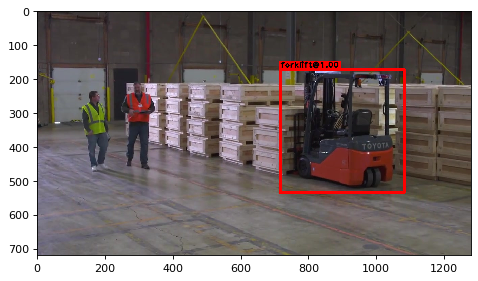

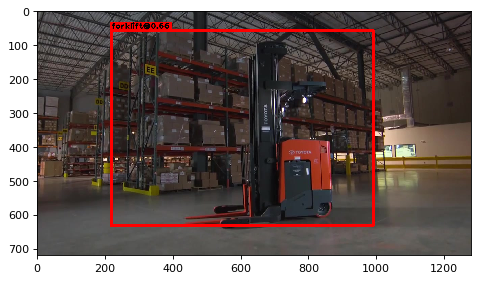

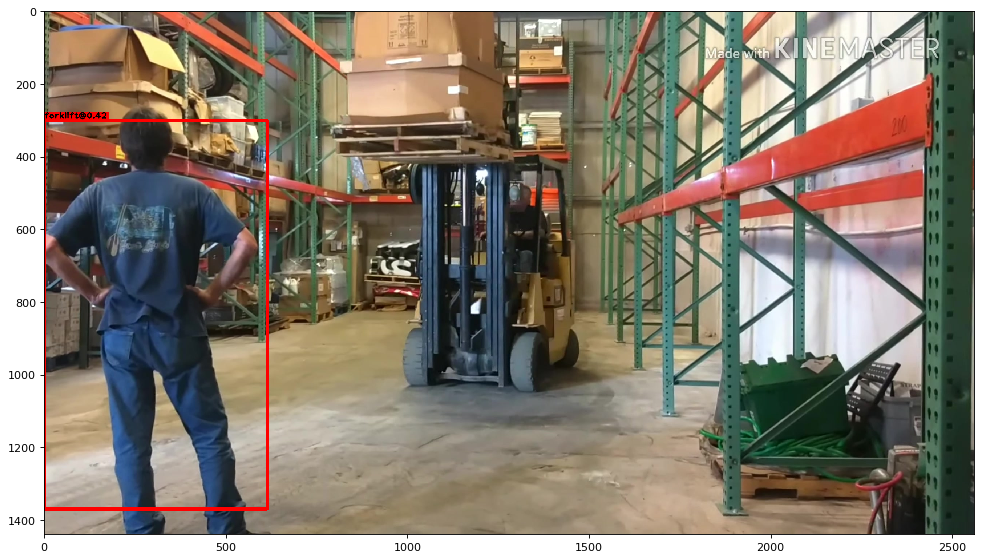

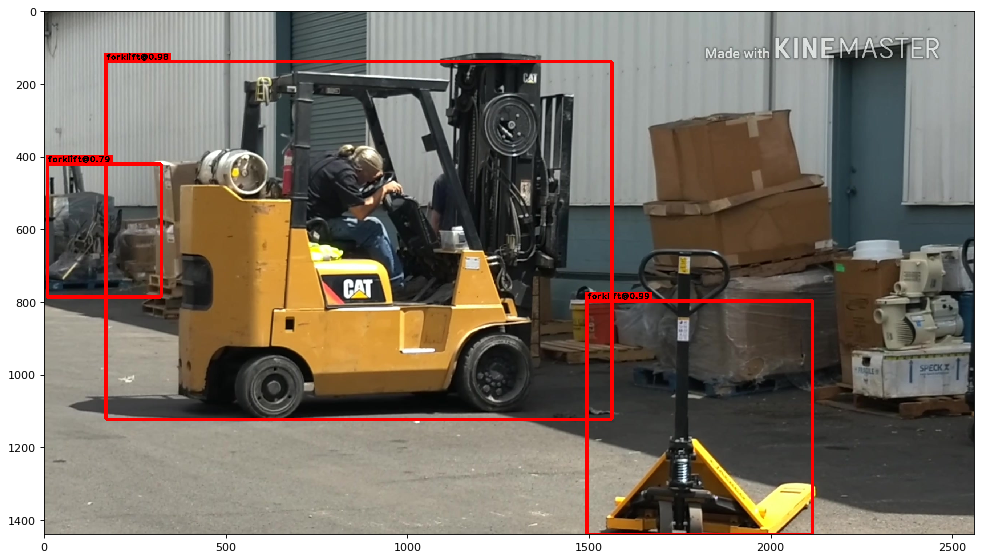

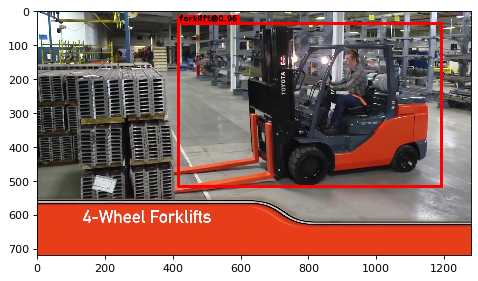

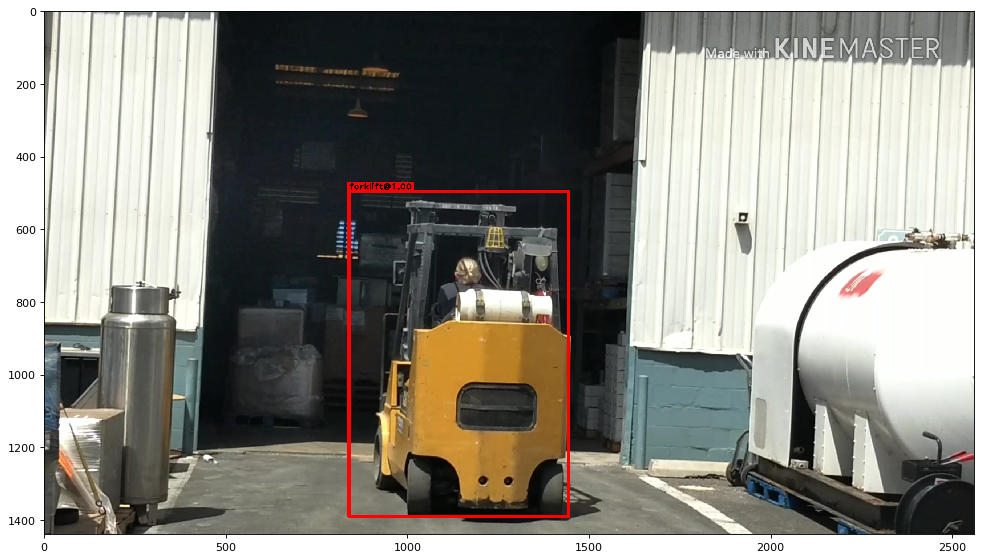

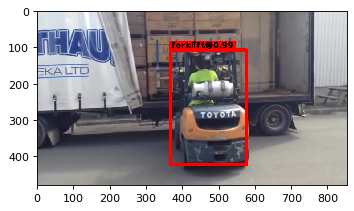

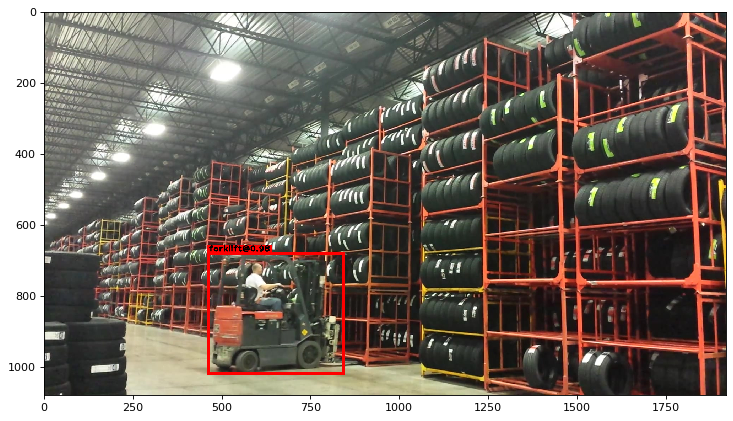

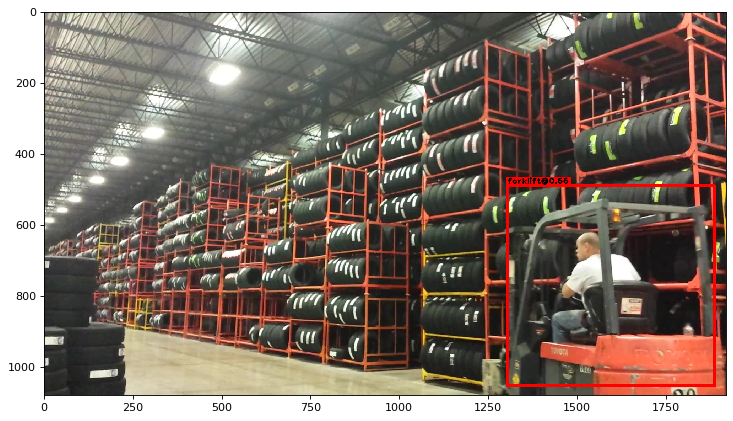

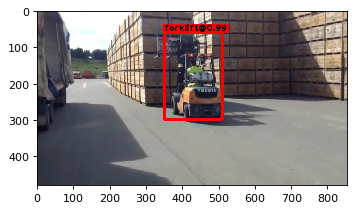

In [5]:
import os
import glob
import json
import boto3
import sagemaker
import cv2

# for displaying images at jupyter notebooks
from matplotlib import pyplot as plt

ALLOWED_EXTENSIONS = set(['png', 'jpg', 'jpeg', 'gif', 'webp', 'bmp'])

def getFiles(base):
    if os.path.isfile(base):
        return [base]
    else:
        return glob.glob(os.path.join(base, '**'), recursive=True)

def drawBB(
    image, header, x, y, xmax, ymax, color=(255, 0, 0), thickness=4*2, text_thickness=1*2,
    text_size=0.8*2, font=cv2.FONT_HERSHEY_PLAIN, footer=""
):
    # bounding box
    cv2.rectangle(image, (x, y), (xmax, ymax), color, thickness)
    
    # header text
    if header != '':
        (text_width, text_height) = cv2.getTextSize(header, font, fontScale=text_size, thickness=text_thickness)[0]
        
        cv2.rectangle(
            image,
            (max(0, int(x-(thickness/2))), max(0, int(y-5-text_height-(thickness/2)))),
            (int(x+text_width+(thickness/2)), int(y)),
            color,
            cv2.FILLED
        )
        
        cv2.putText(image, header, (max(0, x), max(0, y-5)), font, text_size, (0,0,0), text_thickness, cv2.LINE_AA)
        
    if footer != "":
        (footer_width, footer_height) = cv2.getTextSize(footer, font, fontScale=text_size, thickness=text_thickness)[0]
        
        cv2.rectangle(
            image,
            ( int(x-(thickness/2)), int(ymax+(thickness/2)) ),
            ( int(x+footer_width+(thickness/2)), int(ymax+footer_height+(thickness/2)) ),
            color,
            cv2.FILLED
        )
        
        cv2.putText(image, footer, ( x, int(ymax+12+(thickness/2)) ), font, text_size, (0,0,0), text_thickness, cv2.LINE_AA)

# initalize client
sagemaker = boto3.client(
    'runtime.sagemaker',
    region_name='us-east-2'
)

flist = getFiles(INPUT_PATH)
print("Processing: {} files...".format(len(flist)))

for fpath in flist:
    ext = fpath.split('.')[-1].lower() if '.' in fpath else None
    
    # skip unsupported / invalid file extensions
    if ext is None or ext not in ALLOWED_EXTENSIONS:
        continue
    
    # load input
    with open(fpath, 'rb') as fh:
        payload = fh.read()

    # invoke inference
    result = sagemaker.invoke_endpoint(
            EndpointName=ENDPOINT,
            ContentType='image/{}'.format(ext),
            Body=bytearray(payload))
    
    # parse response to json
    response = json.loads(result['Body'].read().decode())
    img = cv2.imread(fpath, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (height, width, channels) = img.shape
    
    try:
        for det in response['input.jpg']['detections']:
            xmin = det['det_bbox'][0] * width
            ymin = det['det_bbox'][1] * height
            xmax = det['det_bbox'][2] * width
            ymax = det['det_bbox'][3] * height
            
            drawBB(img, '{}@{:.2f}'.format(det['label'], det['confidence']), int(xmin), int(ymin), int(xmax), int(ymax))
    # skip when there's no detections
    except:
        pass
    
    # show image in jupyter
    fig, ax = plt.subplots(figsize=(int(1.05 * height / 100), int(1.05 * width / 100)), dpi=80)
    ax.imshow(img, interpolation='nearest')
    plt.show()
    plt.close()
    
    # ..or just save to disk
    # cv2.imwrite('./output/velothes/{}'.format(os.path.basename(fpath)), cv2.cvtColor(img, cv2.COLOR_BGR2RGB))    
    